## *Bruna Fortunato*

Objetivo 1: aplicar o algoritmo de decision tree para realizar uma regressão linear nos dados da Agrisolus.

Objetivo 2: aplicar a regularização no modelo.

In [1]:
### Bibliotecas Principais

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score 
from statistics import mean 

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

import math

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from numpy import median

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import r2_score

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error


### Bancos de Dados Agrisolus

In [3]:
# url para os dados brutos, deixados em um arquivo local e no MS Teams da sprint

url_agrisolus = '/home/hub/Repositorio_aula1/2 Sprint Aulas/4-Regressao_aula _agrisolus_bosch/agrisolus/agrisolus.csv'



### Leitura dos Banco de Dados

* Objetivo Geral: Previsao de pesos
    * Objetivo de específico: Entro com umidade, idbalança, temperatura e o algoritmo retorna o peso

        df_linhagens = Banco de dados das linhagens contando PesoEsperado para uma certa Idade e o IdLinhagem 

        df_lotes = Banco de dados das datas de alojamento com linhagens, peso na chegada e a data de abate   (controle dos lotes)

        df_pesos = Pesagens feitas qdo o frango sobe na balança, tambem mede umidade, temperatura, lote unidade, id da balanda e a data da pesagem (o que é esperado ver aqui é a curva de crescimento do frango)
        
        df_agrisolus = Banco de dados tratado pelo HUB




## Análises Preliminares : Conhecendo o Banco de dados Agrisolus

* Exibindo o Banco de Dados para visualização das instâncias de cada classe: 

In [4]:
df_agrisolus = pd.read_csv(url_agrisolus, sep=';', index_col = 0) #carrega o BD

df_agrisolus.head()   #Visualiza as 5 primeiras linhas do BD Agrisolus


/home/hub/anaconda3/envs/fiep/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Data,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,DataAlojamento,Sexo,PesoChegada,DataAbate,Idade,PesoEsperado,DiffPeso
0,2019-04-06 07:10:35,20.5748,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.0,-21.4252
1,2019-04-06 07:10:43,42.5538,68.2,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.0,0.5538
2,2019-04-06 07:10:58,33.6798,67.9,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.0,-8.3202
3,2019-04-06 07:12:12,25.7238,68.6,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.0,-16.2762
4,2019-04-06 07:13:19,39.4938,68.8,32.0,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.0,-2.5062


* Observando o tamanho do banco de dados de forma Geral :

In [5]:
df_agrisolus.shape

(2075588, 14)

* Observando os Id registrados por Lote:

In [6]:
pd.unique(df_agrisolus['idLote'])

array([2, 1])

* Observando os Id registrados por Linhagem: 

In [7]:
pd.unique(df_agrisolus['idLinhagem'])


array([15, 16])

* Agrupando os dados por idLote e idLinhagem 

In [8]:
id_Linhagem_lote = df_agrisolus.groupby('idLinhagem')['idLote'].count()

id_Linhagem_lote

#Temos para linhagem 15 1091059 lotes e para a linhagem 16, 984529 lotes

idLinhagem
15    1091059
16     984529
Name: idLote, dtype: int64

* Agrupando os dados de Sexo por Lote:

In [9]:
id_Sexo_lote = df_agrisolus.groupby('Sexo')['idLote'].count()

id_Sexo_lote

Sexo
Fêmeas Cobb MV GT Foods    1091059
Mistos Cobb MV GT Foods     984529
Name: idLote, dtype: int64

* Agrupando os dados de Sexo por Linhagem:

In [10]:
id_Sexo_linhagem = df_agrisolus.groupby('Sexo')['idLinhagem'].count()

id_Sexo_linhagem

Sexo
Fêmeas Cobb MV GT Foods    1091059
Mistos Cobb MV GT Foods     984529
Name: idLinhagem, dtype: int64

* Transformando os estados de uma coluna para utilizar como target em um modelo, por exemplo

In [11]:
pd.unique(df_agrisolus['Sexo'])

array(['Fêmeas Cobb MV GT Foods', 'Mistos Cobb MV GT Foods'], dtype=object)

* Temos dois estados, quantos dados registrados de Peso de Chegada temos para cada um?

In [12]:
df_agrisolus.groupby('idBalanca')['PesoChegada'].count()


idBalanca
2843680    492806
2843900    481982
2848352    491723
2861839    609077
Name: PesoChegada, dtype: int64

In [13]:
df_agrisolus.groupby('idLinhagem')['idLinhagem'].count()

idLinhagem
15    1091059
16     984529
Name: idLinhagem, dtype: int64

## Conclusões Gerais

In [14]:
d = {'Tipos de Lote': [1, 2], 'Tipos de Linhagem': [15, 16], 'Linhagem por Lote': [1091059,984529], 'Peso de Chegada por Linhagem':[1091059, 984529]}
df = pd.DataFrame(data=d)

df

,Tipos de Lote,Tipos de Linhagem,Linhagem por Lote,Peso de Chegada por Linhagem
0,1,15,1091059,1091059
1,2,16,984529,984529


*Conclusão:* Existe uma distribuição entre dados por lote mais ou menos uniforme, ou seja 984529 medidos para a Linhagem 16 e 1091059 dados para a Linhagem 15 

## Etapa : Tratamento dos Dados

In [15]:
df_agrisolus

,Data,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,DataAlojamento,Sexo,PesoChegada,DataAbate,Idade,PesoEsperado,DiffPeso
0,2019-04-06 07:10:35,20.5748,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-21.425200
1,2019-04-06 07:10:43,42.5538,68.2,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,0.553800
2,2019-04-06 07:10:58,33.6798,67.9,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-8.320200
3,2019-04-06 07:12:12,25.7238,68.6,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-16.276200
4,2019-04-06 07:13:19,39.4938,68.8,32.0,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-2.506200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075583,2019-05-23 23:56:53,5233.9554,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,1998.129575
2075584,2019-05-23 23:56:55,5238.8098,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,2002.983975
2075585,2019-05-23 23:56:56,5215.1446,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,1979.318775
2075586,2019-05-23 23:56:58,5247.0016,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,2011.175775


* Conferindo o tipo de dados do Banco de Dados

In [16]:
df_agrisolus.dtypes

Data               object
Peso              float64
Umidade           float64
Temperatura       float64
idLote              int64
idLinhagem          int64
idBalanca           int64
DataAlojamento     object
Sexo               object
PesoChegada       float64
DataAbate          object
Idade               int64
PesoEsperado      float64
DiffPeso          float64
dtype: object

* Tratamento de variáveis 

In [17]:
df_agrisolus.isnull().sum()

Data              0
Peso              0
Umidade           0
Temperatura       0
idLote            0
idLinhagem        0
idBalanca         0
DataAlojamento    0
Sexo              0
PesoChegada       0
DataAbate         0
Idade             0
PesoEsperado      0
DiffPeso          0
dtype: int64

* Transformando dados categóricos em colunas

In [5]:
# Transformando a coluna Data em três colunas, Ano Mes e Dia

df_agrisolus['Data'] = pd.to_datetime(df_agrisolus['Data']) #transforma a cikyba oara datetime

df_agrisolus['AnoData'] = df_agrisolus['Data'].dt.strftime('%Y')
df_agrisolus['MesData'] = df_agrisolus['Data'].dt.strftime('%m')
df_agrisolus['DiaData'] = df_agrisolus['Data'].dt.strftime('%d')

df_agrisolus['Hora'] = df_agrisolus['Data'].dt.strftime('%H')
df_agrisolus['Minuto'] = df_agrisolus['Data'].dt.strftime('%M')

del df_agrisolus['Data'] #Remove a coluna Data
df_agrisolus


,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,DataAlojamento,Sexo,PesoChegada,DataAbate,Idade,PesoEsperado,DiffPeso,AnoData,MesData,DiaData,Hora,Minuto
0,20.5748,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-21.425200,2019,04,06,07,10
1,42.5538,68.2,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,0.553800,2019,04,06,07,10
2,33.6798,67.9,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-8.320200,2019,04,06,07,10
3,25.7238,68.6,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-16.276200,2019,04,06,07,12
4,39.4938,68.8,32.0,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,0,42.000000,-2.506200,2019,04,06,07,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075583,5233.9554,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,1998.129575,2019,05,23,23,56
2075584,5238.8098,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,2002.983975,2019,05,23,23,56
2075585,5215.1446,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,1979.318775,2019,05,23,23,56
2075586,5247.0016,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00,1145,3235.825825,2011.175775,2019,05,23,23,56


In [6]:
# Transformando a coluna Data Alojamento em três colunas, Ano Mes e Dia

df_agrisolus['DataAbate'] = pd.to_datetime(df_agrisolus['DataAbate']) #transforma a cikyba oara datetime

df_agrisolus['Ano_abate'] = df_agrisolus['DataAbate'].dt.strftime('%Y')
df_agrisolus['Mes_abate'] = df_agrisolus['DataAbate'].dt.strftime('%m')
df_agrisolus['Dia_abate'] = df_agrisolus['DataAbate'].dt.strftime('%d')

df_agrisolus['Hora_abate'] = df_agrisolus['DataAbate'].dt.strftime('%H')
df_agrisolus['Minuto_abate'] = df_agrisolus['DataAbate'].dt.strftime('%M')



del df_agrisolus['DataAbate'] #Remove a coluna Data
df_agrisolus

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,DataAlojamento,Sexo,PesoChegada,Idade,...,AnoData,MesData,DiaData,Hora,Minuto,Ano_abate,Mes_abate,Dia_abate,Hora_abate,Minuto_abate
0,20.5748,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,0,...,2019,04,06,07,10,2019,05,25,09,30
1,42.5538,68.2,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,0,...,2019,04,06,07,10,2019,05,25,09,30
2,33.6798,67.9,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,0,...,2019,04,06,07,10,2019,05,25,09,30
3,25.7238,68.6,32.1,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,0,...,2019,04,06,07,12,2019,05,25,09,30
4,39.4938,68.8,32.0,2,15,2861839,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,0,...,2019,04,06,07,13,2019,05,25,09,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075583,5233.9554,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,1145,...,2019,05,23,23,56,2019,05,25,09,30
2075584,5238.8098,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,1145,...,2019,05,23,23,56,2019,05,25,09,30
2075585,5215.1446,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,1145,...,2019,05,23,23,56,2019,05,25,09,30
2075586,5247.0016,0.0,0.0,2,15,2843900,2019-04-06 06:30:00,Fêmeas Cobb MV GT Foods,38.0,1145,...,2019,05,23,23,56,2019,05,25,09,30


In [7]:
# Transformando a coluna Data Alojamento em três colunas, Ano Mes e Dia
df_agrisolus['DataAlojamento'] = pd.to_datetime(df_agrisolus['DataAlojamento']) #transforma a cikyba oara datetime


df_agrisolus['Ano_alojamento'] = df_agrisolus['DataAlojamento'].dt.strftime('%Y')
df_agrisolus['Mes_alojamento'] = df_agrisolus['DataAlojamento'].dt.strftime('%m')
df_agrisolus['Dia_alojamento'] = df_agrisolus['DataAlojamento'].dt.strftime('%d')



del df_agrisolus['DataAlojamento'] #Remove a coluna Data
df_agrisolus

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,Sexo,PesoChegada,Idade,PesoEsperado,...,Hora,Minuto,Ano_abate,Mes_abate,Dia_abate,Hora_abate,Minuto_abate,Ano_alojamento,Mes_alojamento,Dia_alojamento
0,20.5748,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,07,10,2019,05,25,09,30,2019,04,06
1,42.5538,68.2,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,07,10,2019,05,25,09,30,2019,04,06
2,33.6798,67.9,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,07,10,2019,05,25,09,30,2019,04,06
3,25.7238,68.6,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,07,12,2019,05,25,09,30,2019,04,06
4,39.4938,68.8,32.0,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,07,13,2019,05,25,09,30,2019,04,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075583,5233.9554,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,23,56,2019,05,25,09,30,2019,04,06
2075584,5238.8098,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,23,56,2019,05,25,09,30,2019,04,06
2075585,5215.1446,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,23,56,2019,05,25,09,30,2019,04,06
2075586,5247.0016,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,23,56,2019,05,25,09,30,2019,04,06


* Codificando variaveis categoricas

In [8]:
from sklearn.preprocessing import LabelEncoder

categ_encod = LabelEncoder()
df_agrisolus["cat_sexo"] = categ_encod.fit_transform(df_agrisolus["Sexo"])
#df_agrisolus[["Sexo", "cat_sexo"]].tail(80)
df_agrisolus.groupby('cat_sexo').count()

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,Sexo,PesoChegada,Idade,PesoEsperado,...,Hora,Minuto,Ano_abate,Mes_abate,Dia_abate,Hora_abate,Minuto_abate,Ano_alojamento,Mes_alojamento,Dia_alojamento
cat_sexo,,,,,,,,,,,,,,,,,,,,,
0,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059,...,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059,1091059
1,984529,984529,984529,984529,984529,984529,984529,984529,984529,984529,...,984529,984529,984529,984529,984529,984529,984529,984529,984529,984529


* Analisando os valores de Peso e desvios de peso por categoria

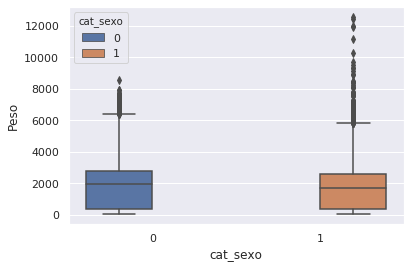

In [22]:
sns.boxplot(x= 'cat_sexo', y='Peso', hue ='cat_sexo', data = df_agrisolus)

* Analise do Peso e DiffPeso por Grupo de Frangos

In [23]:
def calculagrupo(vetor):
    Peso = vetor[1]
    DiffPeso = vetor[0]
    p = abs(DiffPeso/Peso)
    if p < 0.3 :
        return 'ok'
    if p < 0.7 :
        return 'duvidoso'
    if p < 1:
        return 'ta piorando'
    else:
        return 'Pior caso'
    
df_agrisolus['grupo'] = df_agrisolus[['DiffPeso', 'Peso']].apply(calculagrupo,axis =1)



In [24]:
df_agrisolus['grupo'].unique()

array(['Pior caso', 'ok', 'duvidoso', 'ta piorando'], dtype=object)

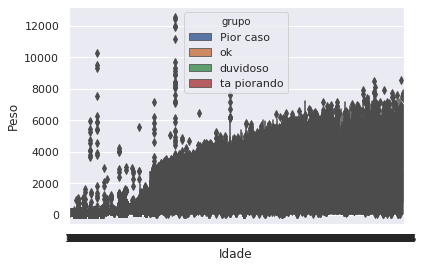

In [25]:
sns.boxplot(x= 'Idade', y='Peso', hue ='grupo', data = df_agrisolus)

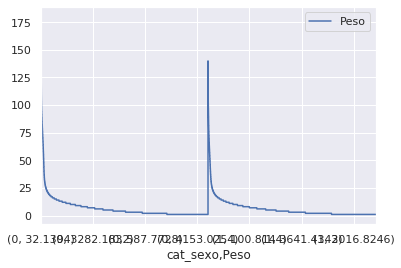

In [26]:
df_agrisolus.groupby('cat_sexo')['Peso'].value_counts().plot(legend = True)

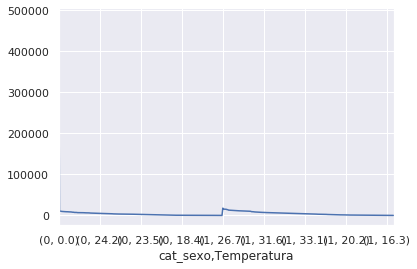

In [27]:
df_agrisolus.groupby('cat_sexo')['Temperatura'].value_counts().plot()

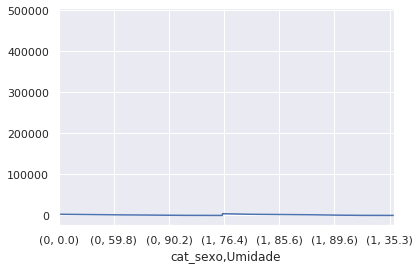

In [28]:
df_agrisolus.groupby('cat_sexo')['Umidade'].value_counts().plot()

Como o plot esta bastante confuso, vamos analisar utilizando a biblioteca seaborn


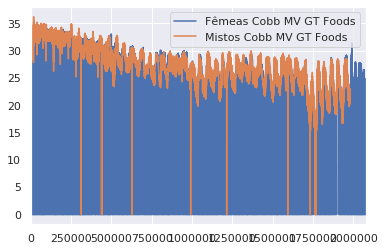

In [29]:
df_agrisolus.groupby('Sexo')['Temperatura'].plot(legend = True)
print("Como o plot esta bastante confuso, vamos analisar utilizando a biblioteca seaborn")

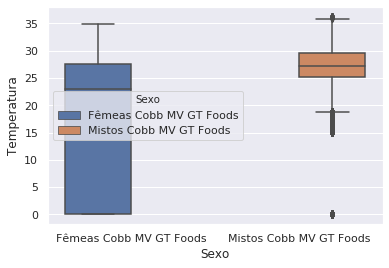

In [30]:
sns.boxplot(x= 'Sexo', y='Temperatura', hue ='Sexo', data = df_agrisolus)

* Umidade pelo Sexo

Sexo
Fêmeas Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Mistos Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Umidade, dtype: object

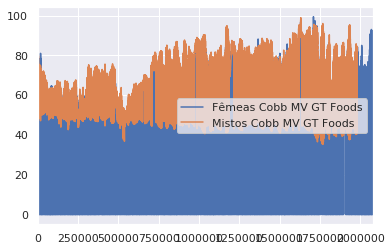

In [31]:
df_agrisolus.groupby('Sexo')['Umidade'].plot(legend = True)

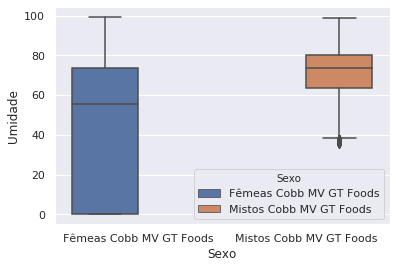

In [32]:
sns.boxplot(x= 'Sexo', y='Umidade', hue ='Sexo', data = df_agrisolus)

* Balanca por Umidade

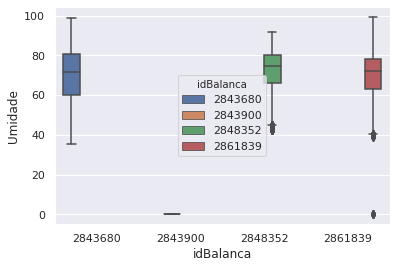

In [33]:
sns.boxplot(x= 'idBalanca', y='Umidade', hue ='idBalanca', data = df_agrisolus)

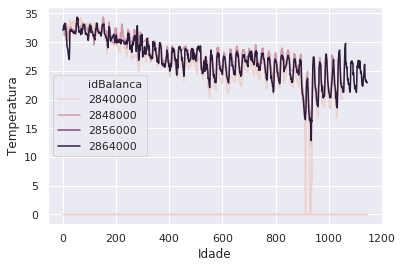

In [34]:
sns.lineplot(x= 'Idade', y='Temperatura', hue ='idBalanca', data = df_agrisolus)

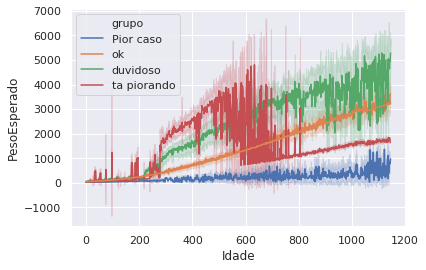

In [35]:
sns.lineplot(x= 'Idade', y='Peso', hue ='grupo',ci='sd', data = df_agrisolus)

sns.lineplot(x= 'Idade', y='PesoEsperado', data = df_agrisolus)

plt.show()


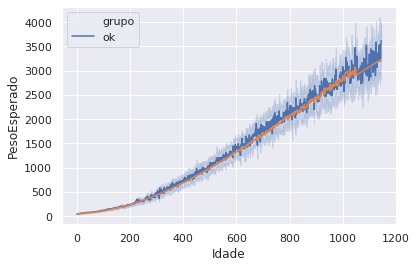

In [36]:
subset = df_agrisolus.loc[df_agrisolus.grupo == 'ok']

sns.lineplot(x= 'Idade', y='Peso', hue ='grupo',ci='sd', data = subset)

sns.lineplot(x= 'Idade', y='PesoEsperado', data = subset)

plt.show()

#subsize = subset.set_index()

* Sexo por Peso por Esperado

Sexo
Fêmeas Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Mistos Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PesoEsperado, dtype: object

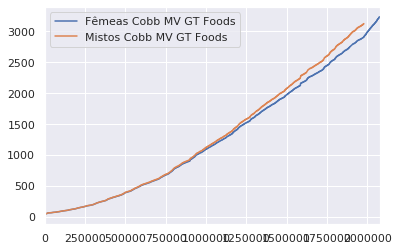

In [37]:
df_agrisolus.groupby('Sexo')['PesoEsperado'].plot(legend = True)

Sexo
Fêmeas Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Mistos Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Peso, dtype: object

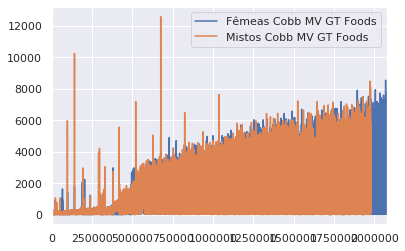

In [38]:

df_agrisolus.groupby('Sexo')['Peso'].plot(legend = True)

Sexo
Fêmeas Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Mistos Cobb MV GT Foods    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Idade, dtype: object

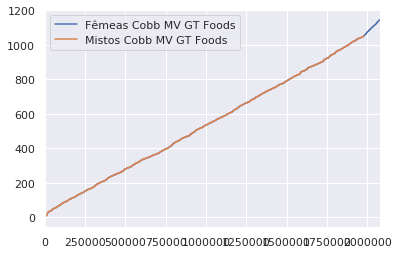

In [39]:
df_agrisolus.groupby('Sexo')['Idade'].plot(legend = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4b80b2f10>,
      dtype=object)

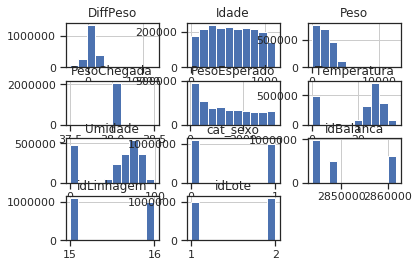

In [42]:
df_agrisolus.hist()

In [43]:
#matriz de correlação dos dados

df_agrisolus.corr()

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,PesoChegada,Idade,PesoEsperado,DiffPeso,cat_sexo
Peso,1.000000,0.041619,-0.191583,0.069038,-0.069038,-0.006531,NaN,0.680386,0.642630,0.668365,-0.069038
Umidade,0.041619,1.000000,0.860991,-0.507837,0.507837,0.419167,NaN,0.152752,0.157726,-0.099345,0.507837
Temperatura,-0.191583,0.860991,1.000000,-0.508240,0.508240,0.430429,NaN,-0.191160,-0.172393,-0.080208,0.508240
idLote,0.069038,-0.507837,-0.508240,1.000000,-1.000000,0.509881,NaN,0.066415,0.038396,0.051938,-1.000000
idLinhagem,-0.069038,0.507837,0.508240,-1.000000,1.000000,-0.509881,NaN,-0.066415,-0.038396,-0.051938,1.000000
idBalanca,-0.006531,0.419167,0.430429,0.509881,-0.509881,1.000000,NaN,0.061618,0.046832,-0.053906,-0.509881
PesoChegada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Idade,0.680386,0.152752,-0.191160,0.066415,-0.066415,0.061618,NaN,1.000000,0.989635,-0.081543,-0.066415
PesoEsperado,0.642630,0.157726,-0.172393,0.038396,-0.038396,0.046832,NaN,0.989635,1.000000,-0.140396,-0.038396
DiffPeso,0.668365,-0.099345,-0.080208,0.051938,-0.051938,-0.053906,NaN,-0.081543,-0.140396,1.000000,-0.051938


## Insites para a exploração de dados

* Altas correlaçoes

    * Peso vs Idade    
    * Peso vs PesoEsperado    
    * Peso vs DiffPeso   
    * Peso Esperado vs Idade   
    * Umidade vs Temperatura   
    * Idade vs PesoEsperado    
    
Obs tentar analisar por lote

### Pelas análises anteriores, Temperatura e Umidade serão descartadas porque apresentam outliers

* Separando os banco de dados por idLote como features

In [9]:
subset_1 = df_agrisolus.loc[df_agrisolus.idLote == 1]  #dados do lote 1

subset_1

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,Sexo,PesoChegada,Idade,PesoEsperado,...,Minuto,Ano_abate,Mes_abate,Dia_abate,Hora_abate,Minuto_abate,Ano_alojamento,Mes_alojamento,Dia_alojamento,cat_sexo
279,25.6778,70.6,32.8,1,16,2848352,Mistos Cobb MV GT Foods,38.0,1,43.335245,...,24,2019,05,20,02,00,2019,04,06,1
280,40.6277,70.7,32.8,1,16,2848352,Mistos Cobb MV GT Foods,38.0,1,43.335245,...,24,2019,05,20,02,00,2019,04,06,1
281,48.5603,70.7,32.8,1,16,2848352,Mistos Cobb MV GT Foods,38.0,1,43.335245,...,24,2019,05,20,02,00,2019,04,06,1
282,39.7124,70.7,32.8,1,16,2848352,Mistos Cobb MV GT Foods,38.0,1,43.335245,...,24,2019,05,20,02,00,2019,04,06,1
283,28.4237,70.9,32.8,1,16,2848352,Mistos Cobb MV GT Foods,38.0,1,43.335245,...,25,2019,05,20,02,00,2019,04,06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977987,2859.1162,84.0,20.1,1,16,2843680,Mistos Cobb MV GT Foods,38.0,1050,3121.117738,...,16,2019,05,20,02,00,2019,04,06,1
1977990,2887.7098,84.0,20.1,1,16,2843680,Mistos Cobb MV GT Foods,38.0,1050,3121.117738,...,16,2019,05,20,02,00,2019,04,06,1
1977991,2862.2242,84.0,20.1,1,16,2843680,Mistos Cobb MV GT Foods,38.0,1050,3121.117738,...,16,2019,05,20,02,00,2019,04,06,1
1977993,2895.1690,84.0,20.1,1,16,2843680,Mistos Cobb MV GT Foods,38.0,1050,3121.117738,...,16,2019,05,20,02,00,2019,04,06,1


### Algoritmo para Classificação por arvore de decisao para o Lote 1

Variaveis utilizadas:
    
X = conjunto de dados para entrada   
y = conjunto de dados para predicao   
tree = Objeto para regressao por arvore de decisao   
y_predict = Dados preditos pelo modelo   
X_train = Conjunto de dados de entrada para treino   
X_test = Conjunto para teste   
y_train = resposta de treino   
y_test = resposta de teste   

In [10]:
X = subset_1.loc[:,['Idade']]
y = subset_1.loc[:,['Peso']]

print(X,y)

         Idade
279          1
280          1
281          1
282          1
283          1
...        ...
1977987   1050
1977990   1050
1977991   1050
1977993   1050
1978408   1051

[984529 rows x 1 columns]               Peso
279        25.6778
280        40.6277
281        48.5603
282        39.7124
283        28.4237
...            ...
1977987  2859.1162
1977990  2887.7098
1977991  2862.2242
1977993  2895.1690
1978408  3436.5826

[984529 rows x 1 columns]


### Inicio do algoritmo

* Inicializando o objeto Arvore de Decisao por regressao

In [11]:
from sklearn.tree import DecisionTreeRegressor  


tree = DecisionTreeRegressor()    


* Dividindo o conjunto a partir dos dados, ou seja, dados para teste e treino do modelo

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 50)

#test_size tamanho da populacao para teste, recomendado 0.3
#random_state quantidade de combinacoes aleatorias 

* Treino do modelo considerando o conjunto para treino

In [13]:
# fit the regressor with X and Y data 
tree.fit(X_train, y_train) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

* Utilizando o modelo treinado em um conjunto de entradas para teste

In [14]:
y_predict_tree= tree.predict(X_test)


* Avaliando a "acuracia" do modelo 

In [15]:
print(r2_score(y_test,y_predict_tree))

0.5815460271427433


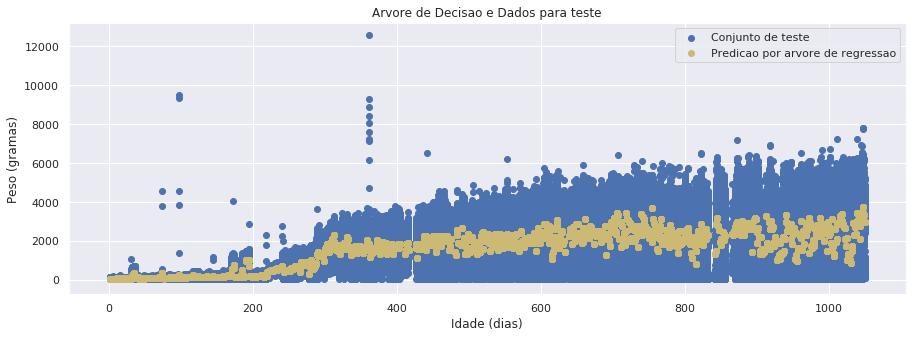

In [46]:
fig,axis = plt.subplots(figsize=(15,5))
plt.scatter(X_test,y_test, color = 'b', label='Conjunto de teste')
plt.scatter(X_test, y_predict_tree, color ='y', label='Predicao por arvore de regressao')
plt.title('Arvore de Decisao e Dados para teste')

plt.xlabel('Idade (dias)')
plt.ylabel('Peso (gramas)')
plt.legend()

plt.grid(True)

* Avaliacao visual dos dados preditos pelo modelo por arvore 

--------------------------
### Avaliando para o Lote 2

In [47]:
subset_2 = df_agrisolus.loc[df_agrisolus.idLote == 2]  #dados do lote 2

subset_2

,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca,Sexo,PesoChegada,Idade,PesoEsperado,...,Minuto,Ano_abate,Mes_abate,Dia_abate,Hora_abate,Minuto_abate,Ano_alojamento,Mes_alojamento,Dia_alojamento,cat_sexo
0,20.5748,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,10,2019,05,25,09,30,2019,04,06,0
1,42.5538,68.2,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,10,2019,05,25,09,30,2019,04,06,0
2,33.6798,67.9,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,10,2019,05,25,09,30,2019,04,06,0
3,25.7238,68.6,32.1,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,12,2019,05,25,09,30,2019,04,06,0
4,39.4938,68.8,32.0,2,15,2861839,Fêmeas Cobb MV GT Foods,38.0,0,42.000000,...,13,2019,05,25,09,30,2019,04,06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075583,5233.9554,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,56,2019,05,25,09,30,2019,04,06,0
2075584,5238.8098,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,56,2019,05,25,09,30,2019,04,06,0
2075585,5215.1446,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,56,2019,05,25,09,30,2019,04,06,0
2075586,5247.0016,0.0,0.0,2,15,2843900,Fêmeas Cobb MV GT Foods,38.0,1145,3235.825825,...,56,2019,05,25,09,30,2019,04,06,0


### Algoritmo para Classificação por arvore de decisao para o Lote 2

Variaveis utilizadas:
    
X_l2 = conjunto de dados para entrada   
y_l2 = conjunto de dados para predicao   
tree_l2 = Objeto para regressao por arvore de decisao   
y_predict_l2 = Dados preditos pelo modelo   
X_train_l2 = Conjunto de dados de entrada para treino   
X_test_l2 = Conjunto para teste   
y_train_l2 = resposta de treino   
y_test_l2 = resposta de teste   

In [48]:
X_l2 = subset_2.loc[:,['Idade']]
y_l2 = subset_2.loc[:,['Peso']]

print(X_l2,y_l2)

         Idade
0            0
1            0
2            0
3            0
4            0
...        ...
2075583   1145
2075584   1145
2075585   1145
2075586   1145
2075587   1145

[1091059 rows x 1 columns]               Peso
0          20.5748
1          42.5538
2          33.6798
3          25.7238
4          39.4938
...            ...
2075583  5233.9554
2075584  5238.8098
2075585  5215.1446
2075586  5247.0016
2075587  5194.5134

[1091059 rows x 1 columns]


### Inicio do algoritmo

* Inicializando o objeto Arvore de Decisao por regressao

In [49]:
from sklearn.tree import DecisionTreeRegressor  


tree_l2 = DecisionTreeRegressor()  

* Dividindo o conjunto a partir dos dados, ou seja, dados para teste e treino do modelo

In [50]:
X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(X_l2,y_l2, test_size = 0.3, random_state = 50)

#test_size tamanho da populacao para teste
#random_state quantidade de combinacoes aleatorias

* Treino do modelo considerando o conjunto para treino

In [51]:
# fit the regressor with X and Y data 
tree.fit(X_train_l2, y_train_l2) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

* Utilizando o modelo treinado em um conjunto de entradas para teste

In [52]:
y_predict_tree_l2= tree.predict(X_test_l2)


* Avaliando a "acuracia" do modelo 

In [53]:
print(r2_score(y_test_l2,y_predict_tree_l2))

0.6387114337709214


* Avaliacao visual dos dados preditos pelo modelo por arvore 

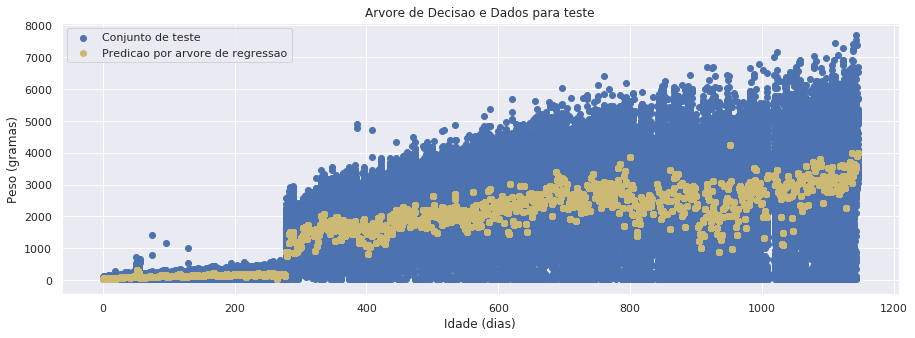

In [54]:
fig,axis = plt.subplots(figsize=(15,5))
plt.scatter(X_test_l2,y_test_l2, color = 'b', label='Conjunto de teste')
plt.scatter(X_test_l2, y_predict_tree_l2, color ='y', label='Predicao por arvore de regressao')
plt.title('Arvore de Decisao e Dados para teste')

plt.xlabel('Idade (dias)')
plt.ylabel('Peso (gramas)')
plt.legend()

plt.grid(True)

## Comparando com regularizacao

629086.1901685811
629080.8785924163


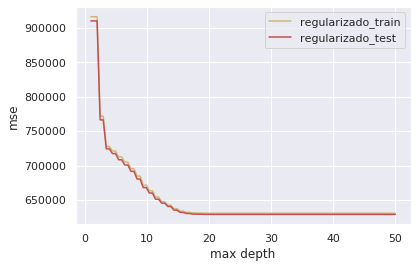

In [55]:
depth_test =  np.linspace(1., 50., num=100)

erros_train = []
erros_test = []


for depth in depth_test:
    
    #modelo_regularizado =  DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train.values.ravel())
    modelo_regularizado =  DecisionTreeRegressor(max_depth=depth).fit(X_train_l2, y_train_l2)
    y_pred = modelo_regularizado.predict(X_test_l2)
    
    #erros
    erros_train.append(mean_squared_error(y_train_l2, modelo_regularizado.predict(X_train_l2)))
    erros_test.append(mean_squared_error(y_test_l2, y_pred))
    
    lastMSE = mean_squared_error(y_test_l2, y_pred)

print(lastMSE)
X_new = np.array(erros_test)

print(np.amin(X_new))

plt.plot(depth_test, erros_train,color='y',label='regularizado_train')
plt.plot(depth_test, erros_test,color='r',label='regularizado_test')    
plt.xlabel('max depth')
plt.ylabel('mse')
plt.legend()

In [56]:
# Modelo sem regularização
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
r2_tree = r2_score(y_test, y_pred)

# Modelo com profundidade máxima igual a 1
tree_dep1 = DecisionTreeRegressor(max_depth=1)
tree_dep1.fit(X_train, y_train)
y_pred_dep1 = tree_dep1.predict(X_test)
r2_tree_dep1 = r2_score(y_test, y_pred_dep1)

R2 - Sem regularização: 0.5815460271427433
R2 - Com regularização: 0.5815460271427433
R2 - Produndidade igual a 1: 0.44148582748901544


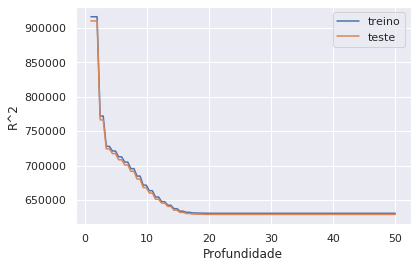

In [57]:
print('R2 - Sem regularização:', r2_tree)
print('R2 - Com regularização:', r2_tree)
print('R2 - Produndidade igual a 1:', r2_tree_dep1)


fig,axs = plt.subplots()
axs.plot(depth_test,erros_train)
axs.plot(depth_test,erros_test)
axs.set_xlabel('Profundidade')
axs.set_ylabel('R^2')
axs.legend(['treino','teste'])
axs.grid('on')

* O R2 com regulazicao e sem regularizacao apresentam os mesmos valores. Em conclusao, a arvore realizou a poda dos galhos menos significativos.